In [1]:
from chin_chime.face_landmark_extractor import (
    get_mp_detecion, draw_landmarks_on_image, plot_face_blendshapes_bar_graph, get_landmarks
)
from chin_chime.realtime_detection import run_emotion_detction
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np

2024-09-12 18:10:54.991101: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-12 18:10:55.006785: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-12 18:10:55.024900: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-12 18:10:55.030377: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-12 18:10:55.043648: I tensorflow/core/platform/cpu_feature_guar

In [2]:
test_df = pd.read_csv('./fer2013/test.csv')
train_df = pd.read_csv('./fer2013/train.csv')

In [3]:
train_df['emotion'].value_counts()

emotion
3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: count, dtype: int64

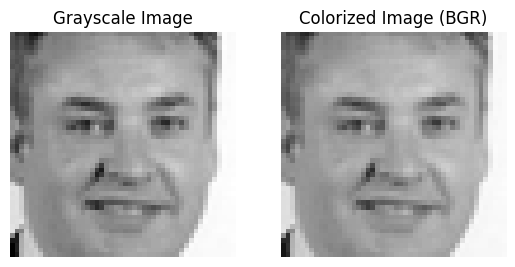

((48, 48, 3), (48, 48, 1))

In [4]:
pixel_str = test_df.iloc[200]['pixels']
pixels = np.array([*map(int, pixel_str.split())])
gray = np.reshape(pixels, (48, 48, 1))
gray = gray.astype(np.uint8)
img_bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

# Plot the original grayscale image
plt.subplot(1, 2, 1)
plt.imshow(gray.squeeze(), cmap='gray')
plt.title('Grayscale Image')
plt.axis("off")

# Plot the colorized (BGR) image
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper color display in matplotlib
plt.title('Colorized Image (BGR)')
plt.axis("off")
plt.show()

img_bgr.shape, gray.shape

/home/cv/anaconda3/envs/tte/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


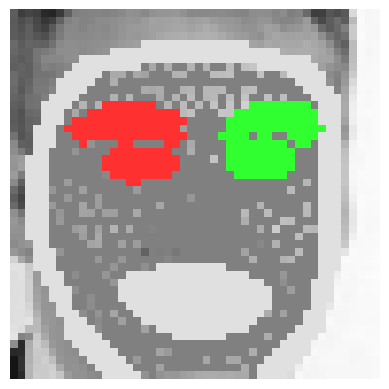

In [5]:
detection = get_mp_detecion(img_bgr)
annotated_img = draw_landmarks_on_image(img_bgr, detection_result=detection)
annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)
plt.imshow(annotated_img)
plt.axis("off")
plt.show()

In [6]:
get_landmarks(img_bgr).shape

(478, 3)

In [7]:
from tqdm import tqdm
import os
from numpy import ndarray


id2label = {
    0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4:"Sad", 5: "Surprise", 6:"Neutral"
}
label2id = {v:k for k, v in id2label.items()}


def pixel_to_image(pixels: str)->ndarray:
    pixels = np.array([*map(int, pixels.split())])
    gray = np.reshape(pixels, (48, 48, 1))
    gray = gray.astype(np.uint8)
    img_bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    return img_bgr


def build_dataset_fom_df(df: pd.DataFrame, mode: str,  base_folder: str='./fer2013/raw/'):
    base_folder = os.path.join(base_folder, mode)
    os.makedirs(base_folder, exist_ok=True)
    n = df.shape[0]
    skip_count = 0
    for i in tqdm(range(n)):
        if mode == "train":
            emotion = id2label[df.iloc[i]['emotion']]
            emotion_folder = os.path.join(base_folder, emotion)
        else:
            emotion_folder = base_folder

        os.makedirs(emotion_folder, exist_ok=True)

        pixels = df.iloc[i]['pixels']
        image = pixel_to_image(pixels)
        landmarks = get_landmarks(image)
        if landmarks is None:
            skip_count += 1
            print("Skipping: ", i, "skip_count: ", skip_count)
            continue
        np.save(os.path.join(emotion_folder, str(i)+'.npy'), landmarks)        

def build_dataset(train_df, test_df):
    print("Building Train Dataset: ")
    build_dataset_fom_df(train_df, mode="train")
    print("Building Test Dataset: ")
    # build_dataset_fom_df(test_df, "test")

# build_dataset(train_df, test_df)

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
import random

class LandMarks(Dataset):
    def __init__(self, dataset_path: str, mode: str, lower_only: bool, split: float=0.75):
        self.lower_only = lower_only
        
        self._paths = self._load_paths(dataset_path, mode, split)
        self.paths = []
        skip_count = 0
        for path in tqdm(self._paths):
            try: 
                np.load(path)
                self.paths.append(path)
                continue
            except:
                skip_count += 1
        print(len(self.paths), "Skip Count: ", skip_count)
        random.shuffle(self.paths)
        
        self.id2label = {
            0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4:"Sad", 5: "Surprise", 6:"Neutral"
        }
        self.label2id = {v:k for k, v in id2label.items()}
        self.lower_landmark_ids = self._get_lower_face_landmark_ids()
        
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        path = self.paths[index]
        item = torch.tensor(np.load(path), dtype=torch.float32)
        if self.lower_only:
            item = item[self.lower_landmark_ids]
        label = torch.tensor(self.label2id[path.split('/')[-2]])
        return (item, label)        
        
    def _load_paths(self, base_folder: str, mode: str, split: float) -> list:
        
        emotions = [os.path.join(base_folder, emo) for emo in os.listdir(base_folder)]
        paths = []
        for emo in emotions:
            files = os.listdir(emo)
            if mode == 'train':
                start = 0
                end = int(len(files) * split)
            elif mode == 'test':
                start = int(len(files) * split)
                end = len(files)
            else:
                raise ValueError("Sanity Check: No mode other than train and test is defined")
            files = files[start: end]
            for file in files:
                paths.append(os.path.join(emo, file))
        # paths = [os.path.join(emo, file) for emo in emotions for file in os.listdir(emo)]
        return paths
    
    def _get_lower_face_landmark_ids(self):
        # Dictionary of lower face landmarks
        lower_face_landmarks = {
            "jawline": list(range(0, 17)),  # Landmarks 0 to 16
            "chin": [152],  # Landmark 152

            "outer_lip_contour": list(range(61, 69)) + list(range(75, 79)) + list(range(191, 196)) + [61, 291],
            # Landmarks 61-68, 75-78, 191-195, 61 (left corner), 291 (right corner)
            
            "inner_lip_contour": list(range(78, 83)) + list(range(87, 92)) + [88, 324],
            # Landmarks 78-82, 87-91, 88 (left corner), 324 (right corner)

            "lower_cheek_contours": list(range(127, 133)) + list(range(134, 137)) + [147, 148],
            # Landmarks 127-132, 134-136, 147-148

            "chin_to_lip_connection": list(range(17, 21)) + [317, 318]
            # Landmarks 17-20, 317-318
        }

        # Convert all landmark indices to a single list
        all_landmarks = []

        # Iterate over the dictionary and extend the list with each set of landmarks
        for key, indices in lower_face_landmarks.items():
            all_landmarks.extend(indices)

        # Remove duplicates by converting to a set and then back to a sorted list
        unique_landmarks = sorted(set(all_landmarks))

        # Print the resulting list of unique landmarks
        return unique_landmarks


# BATCH_SIZE = 64
# # dataset = LandMarksLower(save_folder)
# # train, test = split_dataset(dataset, 0.75, random_seed=42)

# train_data = LandMarks('fer2013/raw/train/', mode='train', lower_only=False, split=0.75)
# test_data = LandMarks('fer2013/raw/train/', mode='test', lower_only=False, split=0.75)
# trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
# testloader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [9]:
from sklearn.metrics import accuracy_score

test_acc = []
test_loss = [0]
train_loss = [0]
train_step = [0]


def train(weights_save_path):
    
    '''
    Updates the global variables need to check that
    '''
    
    eval_loss = 0.0
    eval_acc = 0.0
    max_eval_acc = -1
    
    for epoch in range(epochs):
        model.train()
        
        for i, batch in enumerate(trainloader):
            # zero gradients
            optimizer.zero_grad()
            
            landmarks, labels = batch
            landmarks: torch.Tensor =landmarks.to(device)
            labels: torch.Tensor = labels.to(device)
            
            logits = model(landmarks)
            loss: torch.Tensor = criterion(logits, labels)
            
            
            #back_prop
            loss.backward()
            optimizer.step()
            
            if i % 250 == 0:
                print(f"Epoch: {epoch} | Loss: {loss.item():.4f} | Last Eval Loss: {eval_loss:.4f}| Last Eval Accuracy: {eval_acc:.4f}")
            
            # track stats
            train_loss.append(loss.item())
            train_step.append(train_step[-1] + 1)
        
        # evaluate the model
        eval_loss, eval_acc = test()
        
        # track evaluation dataset stats
        test_acc.append(eval_acc)
        test_loss.append(eval_loss)
        
        # save the best model
        if eval_acc > max_eval_acc:
            torch.save(model.state_dict(), weights_save_path)
            max_eval_acc = eval_acc
        
    print("Evaluation Loss: ",  eval_loss, eval_acc)
    
    
@torch.no_grad()         
def test():
    preds_ = []
    labels_ = []
    eval_loss = []
    model.eval()
    for i, batch in enumerate(testloader):
        
        landmarks, labels = batch
        landmarks = landmarks.to(device)
        labels = labels.to(device)
        
        logits = model(landmarks)
        
        preds = torch.argmax(logits, dim=1)
        preds_.extend((preds.cpu().tolist()))
        labels_.extend(labels.cpu().tolist())
        
        loss = criterion(logits, labels)
        
        eval_loss.append(loss.item())
    
    return (sum(eval_loss)/len(eval_loss), accuracy_score(preds_, labels_))


import torch.nn as nn

class MLPLandmark(nn.Module):
    def __init__(self, inp_landmarks: int, out_dim: int, layers: list, dim_per_landmark: int=3):
        super().__init__()
        
        self.inp_dim = inp_landmarks * dim_per_landmark
        
        self.mlp = nn.ModuleList()
        
        self.mlp.append(nn.Linear(self.inp_dim, layers[0]))
        
        for i in range(1, len(layers)):
            self.mlp.append(
                nn.Sequential(
                    nn.Linear(layers[i-1], layers[i]),
                    nn.ReLU(),
                    nn.LayerNorm(layers[i])
                )
            )
        
        self.mlp.append(nn.Linear(layers[-1], out_dim))
        
    def forward(self, x: torch.Tensor):
        x = x.view(x.shape[0], self.inp_dim)
        
        for layer in self.mlp:
            x = layer(x)
        
        return x
    

In [12]:
device='cuda:1'
epochs = 200
lr = 1e-4


model = MLPLandmark(inp_landmarks=478, out_dim=7, layers=[1024, 1024, 1024], dim_per_landmark=3).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

BATCH_SIZE = 64
# dataset = LandMarks(save_folder)
# train, test = split_dataset(dataset, 0.75, random_seed=42)
dataset_path = './fer2013/raw/train/'
train_data = LandMarks(dataset_path, 'train', lower_only=False, split=0.75)
test_data = LandMarks(dataset_path, mode='test', lower_only=False, split=0.75)

trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_data, batch_size=BATCH_SIZE)


100%|██████████| 21529/21529 [00:07<00:00, 2813.16it/s]


19271 Skip Count:  2258


100%|██████████| 7180/7180 [00:02<00:00, 3499.48it/s]

6441 Skip Count:  739


In [13]:
test_acc = []
test_loss = [0]
train_loss = [0]
train_step = [0]

model_save_weight_path = './model_weights/landmark_all_fer.pt'
train(model_save_weight_path)

Epoch: 0 | Loss: 1.8424 | Last Eval Loss: 0.0000| Last Eval Accuracy: 0.0000
Epoch: 0 | Loss: 1.5574 | Last Eval Loss: 0.0000| Last Eval Accuracy: 0.0000
Epoch: 1 | Loss: 1.6801 | Last Eval Loss: 1.7015| Last Eval Accuracy: 0.3288
Epoch: 1 | Loss: 1.5881 | Last Eval Loss: 1.7015| Last Eval Accuracy: 0.3288
Epoch: 2 | Loss: 1.4831 | Last Eval Loss: 1.4274| Last Eval Accuracy: 0.4257
Epoch: 2 | Loss: 1.5787 | Last Eval Loss: 1.4274| Last Eval Accuracy: 0.4257
Epoch: 3 | Loss: 1.5191 | Last Eval Loss: 1.3745| Last Eval Accuracy: 0.4783
Epoch: 3 | Loss: 1.2554 | Last Eval Loss: 1.3745| Last Eval Accuracy: 0.4783
Epoch: 4 | Loss: 1.3656 | Last Eval Loss: 1.4022| Last Eval Accuracy: 0.4706
Epoch: 4 | Loss: 1.3463 | Last Eval Loss: 1.4022| Last Eval Accuracy: 0.4706
Epoch: 5 | Loss: 1.3805 | Last Eval Loss: 1.4180| Last Eval Accuracy: 0.4683
Epoch: 5 | Loss: 1.2895 | Last Eval Loss: 1.4180| Last Eval Accuracy: 0.4683
Epoch: 6 | Loss: 1.5152 | Last Eval Loss: 1.4108| Last Eval Accuracy: 0.4628

Text(0, 0.5, 'Loss')

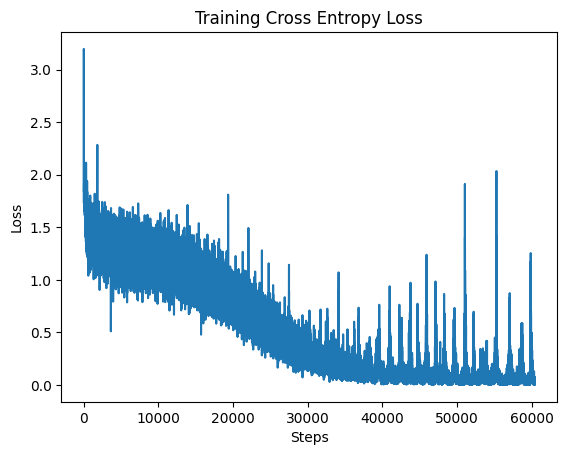

In [14]:
import matplotlib.pyplot as plt

plt.plot(train_step[1:], train_loss[1:])
plt.title("Training Cross Entropy Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy Score %')

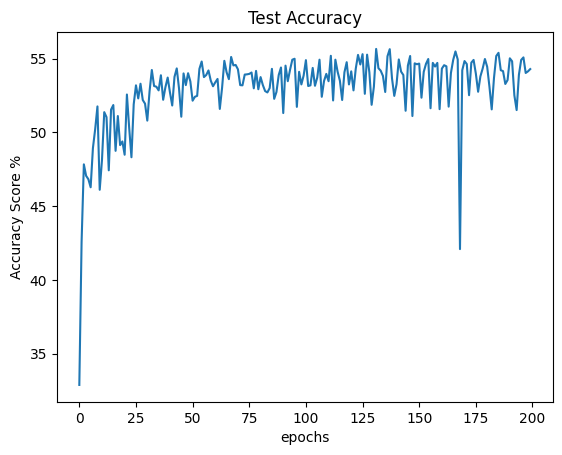

In [15]:
plt.plot(np.array(test_acc) * 100)
plt.title("Test Accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy Score %")

In [16]:
device='cuda:1'
epochs = 200
lr = 1e-3


model = MLPLandmark(inp_landmarks=63, out_dim=7, layers=[1024, 1024, 1024], dim_per_landmark=3).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

BATCH_SIZE = 64
# dataset = LandMarks(save_folder)
# train, test = split_dataset(dataset, 0.75, random_seed=42)
dataset_path = './fer2013/raw/train/'
train_data = LandMarks(dataset_path, 'train', lower_only=True, split=0.75)
test_data = LandMarks(dataset_path, mode='test', lower_only=True, split=0.75)

trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_data, batch_size=BATCH_SIZE)

100%|██████████| 21529/21529 [00:07<00:00, 2843.67it/s]


19271 Skip Count:  2258


100%|██████████| 7180/7180 [00:01<00:00, 3943.32it/s]

6441 Skip Count:  739


Text(0, 0.5, 'Loss')

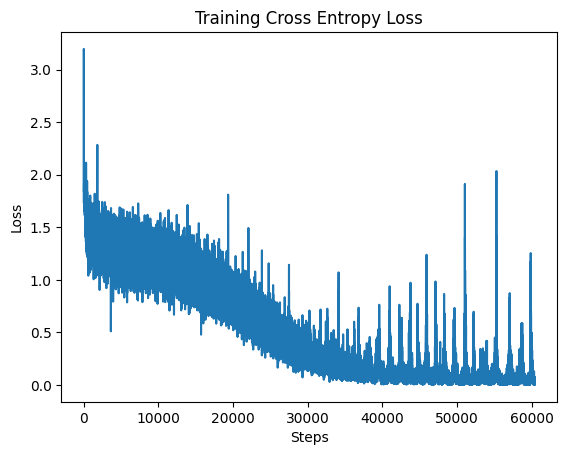

In [17]:
plt.plot(train_step[1:], train_loss[1:])
plt.title("Training Cross Entropy Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy Score %')

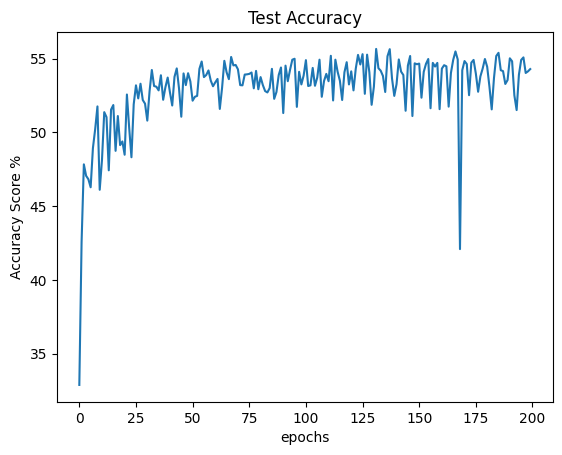

In [18]:
plt.plot(np.array(test_acc) * 100)
plt.title("Test Accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy Score %")